In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import sys
sys.path.append("C:/Users/cnava/Repos/PolaPy")

from polapy.competitiveness import blais_lago, endersby_etal, grofman_selb, navarrete_etal as competitiveness
from polapy.polarization import navarrete_etal as polarization, esteban_ray

In [2]:
country, year, election, aggregation = "Canada", 2021, "federal", "state"
# country, year, election, aggregation = "France", 2022, "first_round", "department_id"

input_df_location = pd.read_csv(f"../data_output/{country}/{year}_{election}_location.csv.gz", compression="gzip")
input_df = pd.read_csv(f"../data_output/{country}/{year}_{election}.csv.gz")
input_df = pd.merge(input_df, input_df_location[["polling_id", aggregation]])
if country == "France":
    input_df = input_df[~input_df[aggregation].astype(str).str.contains("Z")]

if "flag_candidates" in list(input_df):
    input_df = input_df[input_df["flag_candidates"] == 1]

input_df.head()

,polling_id,candidate,value,rate,rank,state
0,10001- 1-Freshwater,Conservative,28,0.280000,2,Newfoundland and Labrador
1,10001- 1-Freshwater,Liberal,55,0.550000,1,Newfoundland and Labrador
2,10001- 1-Freshwater,NDP-New Democratic Party,13,0.130000,3,Newfoundland and Labrador
3,10001- 1-Freshwater,People's Party - PPC,4,0.040000,4,Newfoundland and Labrador
4,10001- 10-Carbonear,Conservative,35,0.406977,2,Newfoundland and Labrador


In [8]:
candidates = input_df.groupby("candidate").agg({"value": "sum"}).sort_values("value", ascending=False).reset_index()
candidates["cumulative"] = candidates["value"].cumsum() / candidates["value"].sum()
candidates["N_candidates"] = range(1, candidates.shape[0] + 1)

candidates["year"] = year
candidates.to_csv(f"../data_robustness/{country}/cumulative_{year}.csv", index=False)
candidates

,candidate,value,cumulative,N_candidates,year
0,Conservative,5747410,0.337403,1,2021
1,Liberal,5556629,0.663607,2,2021
2,NDP-New Democratic Party,3036348,0.841856,3,2021
3,Bloc Québécois,1301615,0.918268,4,2021
4,People's Party - PPC,840993,0.967639,5,2021
5,Green Party,396988,0.990944,6,2021
6,Free Party Canada,47252,0.993718,7,2021
7,Maverick Party,35178,0.995783,8,2021
8,Independent,25605,0.997286,9,2021
9,Christian Heritage Party,8985,0.997814,10,2021


In [4]:
output = []

n_total = min(candidates.shape[0] + 1, 16)
for N_candidates in set(list(range(2, n_total)) + [candidates.shape[0]]):
    cnd = candidates.head(N_candidates)["candidate"].unique()

    df = input_df[input_df["candidate"].isin(cnd)].copy()
    df_frag = input_df[~input_df["candidate"].isin(cnd)].copy()
    df_frag["candidate"] = "OTHER"
    df = pd.concat([df, df_frag])

    tt = df.groupby([aggregation, "polling_id", "candidate"]).agg({"value": "sum"})
    tt["rate"] = tt.groupby(level=[0, 1], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index()

    for idx, data in tt.groupby(aggregation):
        within, ag = polarization(data, unit="polling_id", votes="value")
        between, ag = competitiveness(data, unit="polling_id", votes="value")
        output.append({
            aggregation: idx,
            "ep": within,
            "ec": between,
            "N_candidates": N_candidates
        })

output_df = pd.DataFrame(output)
output_df["year"] = year
output_df.to_csv(f"../data_robustness/{country}/candidates_{year}.csv", index=False)
output_df.head()

,state,ep,ec,N_candidates,year
0,Alberta,0.158911,0.711212,2,2021
1,British Columbia,0.189961,0.778350,2,2021
2,Manitoba,0.219176,0.746336,2,2021
3,New Brunswick,0.186948,0.758925,2,2021
4,Newfoundland and Labrador,0.169863,0.750408,2,2021


In [5]:
output_df = pd.DataFrame(output)
output_df["year"] = year
output_df.to_csv(f"../data_robustness/{country}/candidates_{year}.csv", index=False)
output_df.head()

,state,ep,ec,N_candidates,year
0,Alberta,0.158911,0.711212,2,2021
1,British Columbia,0.189961,0.778350,2,2021
2,Manitoba,0.219176,0.746336,2,2021
3,New Brunswick,0.186948,0.758925,2,2021
4,Newfoundland and Labrador,0.169863,0.750408,2,2021


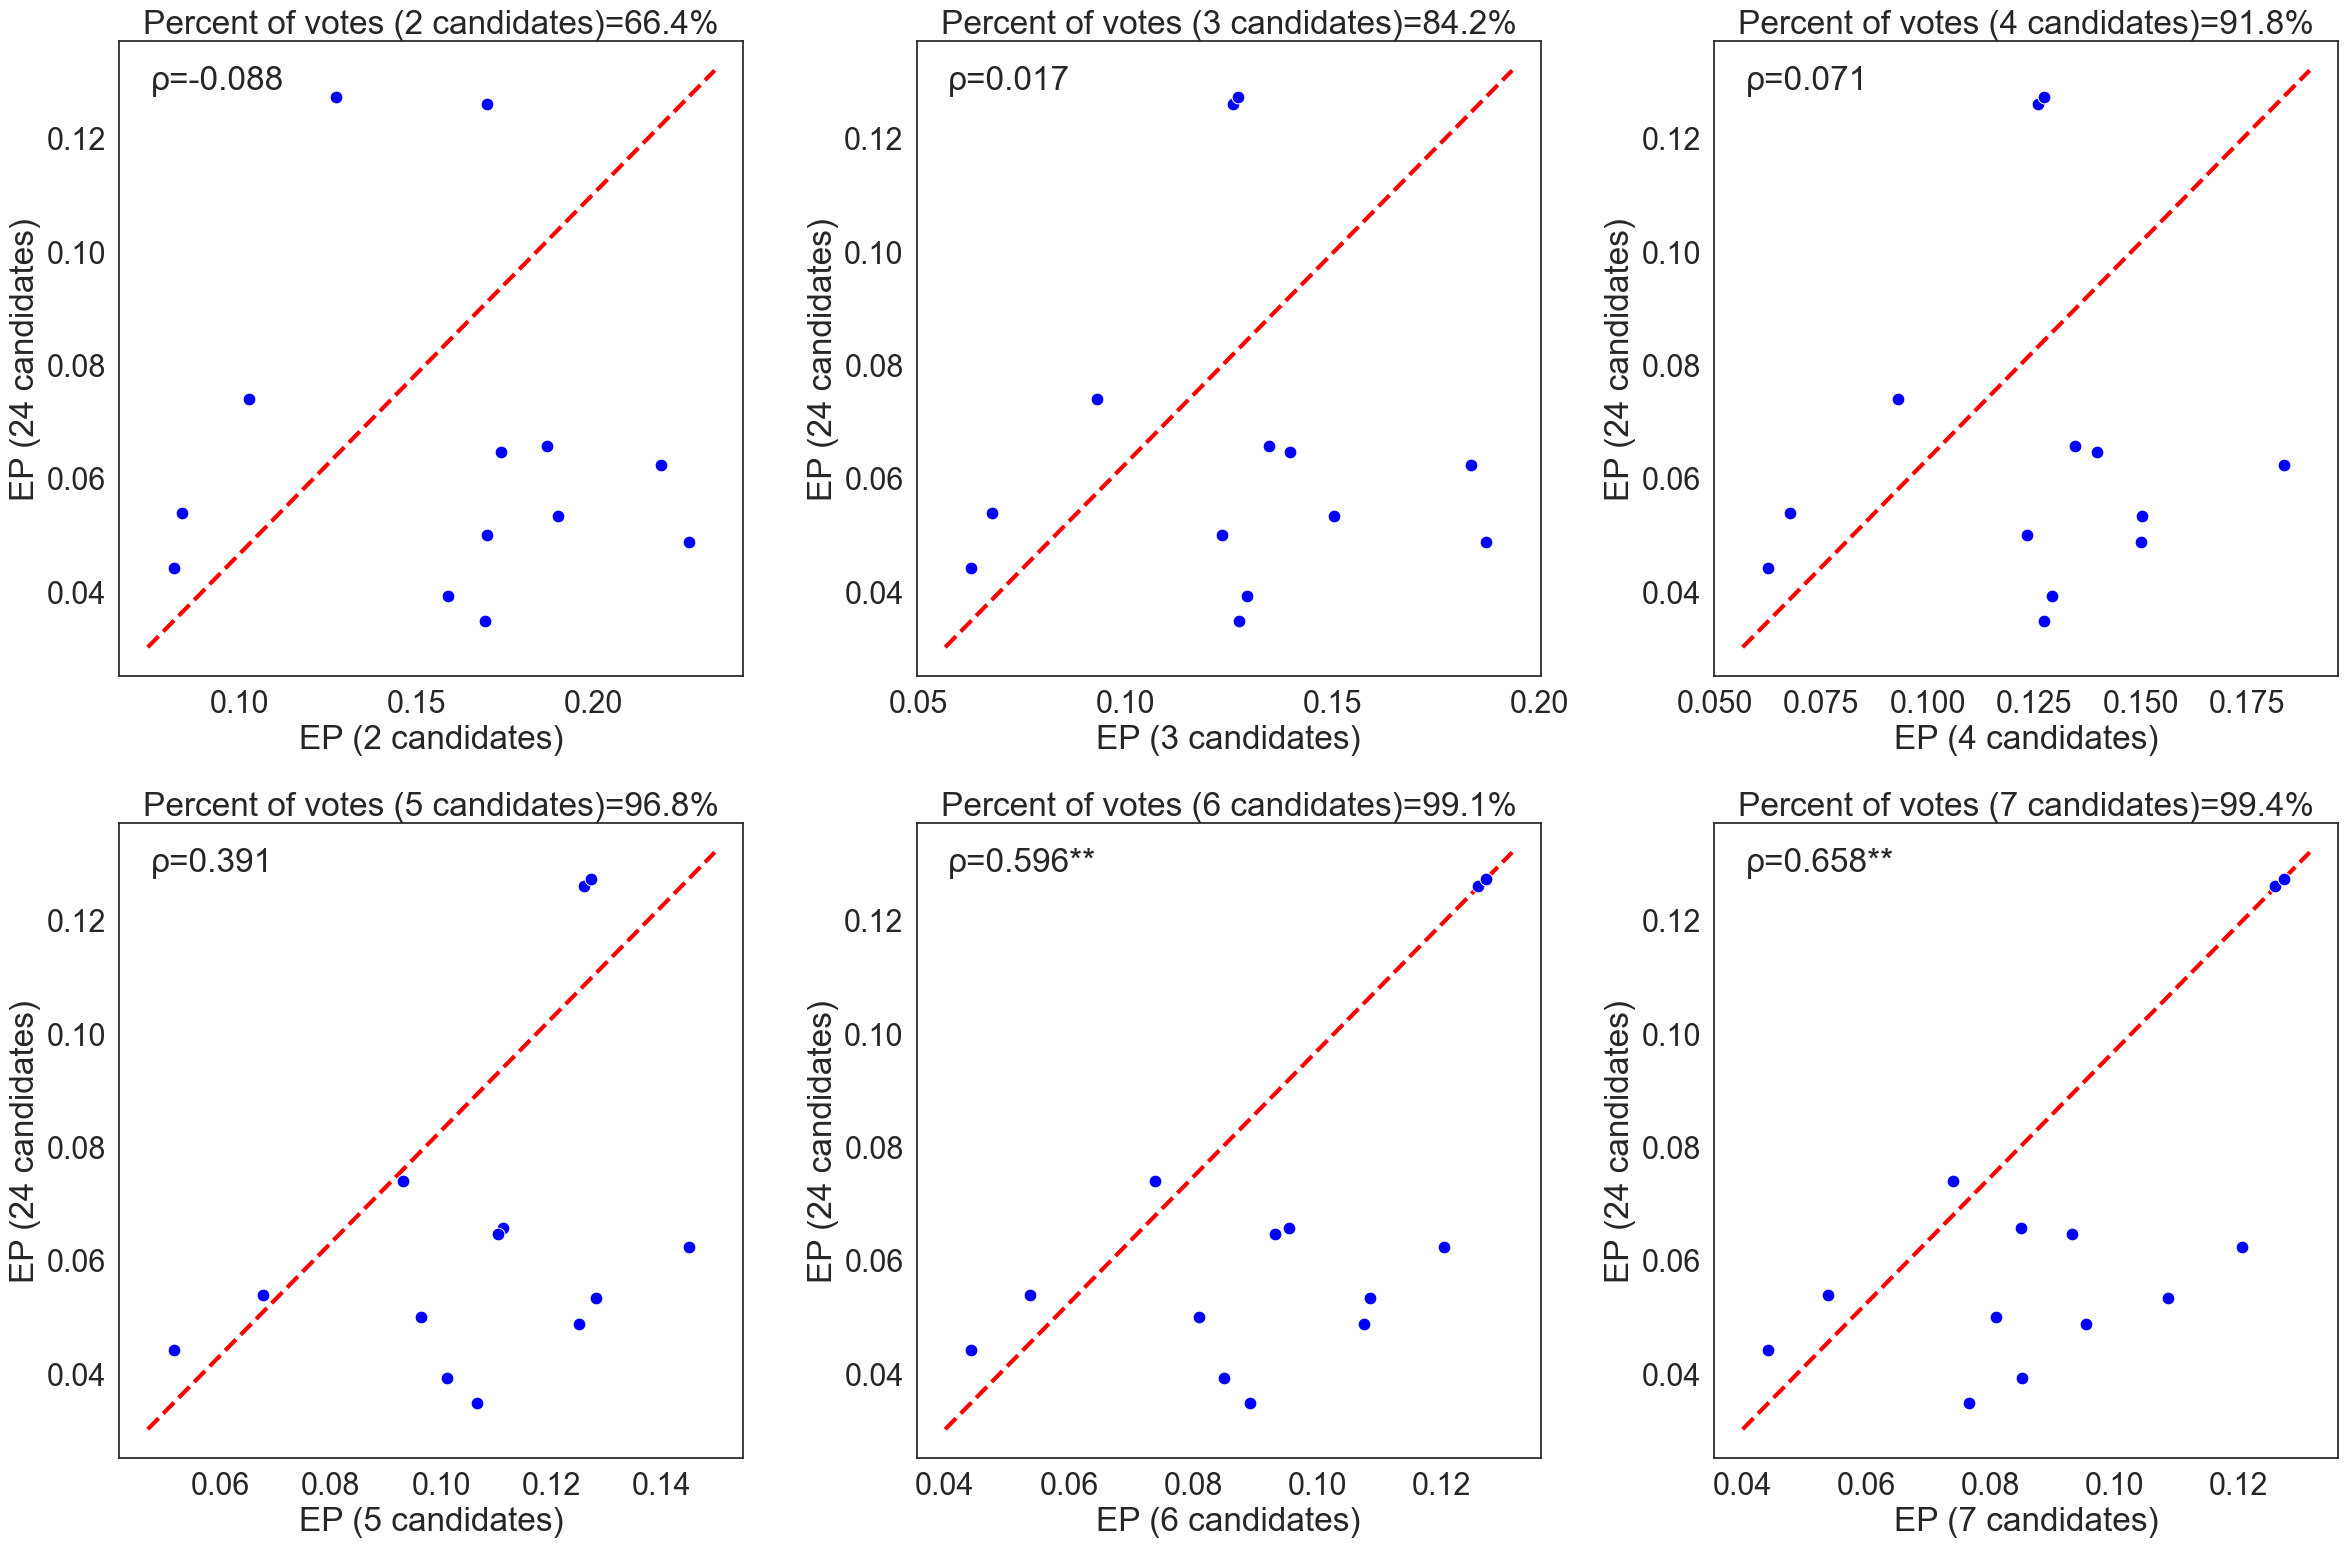

In [7]:
sns.set(font_scale=2, style="white")

if country in ["France", "Spain"]:
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
else:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

threshold = 10 + 1
if country not in ["France", "Spain"]:
    threshold = 7 + 1

metric = "ep"

for N_candidates in range(2, min(candidates.shape[0] + 1, threshold)): #10 + 1

    idx = N_candidates - 2
    ax = axs[int(idx/3), idx%3]

    data = pd.merge(
        output_df[output_df["N_candidates"] == N_candidates],
        output_df[output_df["N_candidates"] == candidates.shape[0]],
        on=aggregation
    )

    sns.scatterplot(
        x=f"{metric}_x",
        y=f"{metric}_y",
        data=data,
        # linewidth=0.25,
        s=85,
        zorder=2,
        color="blue",
        ax=ax
    )

    corr, pvalue = pearsonr(data[f"{metric}_x"], data[f"{metric}_y"])
    def corrfunc(corr, pvalue, ax):
        ax = plt.gca()
        note = ""
        if pvalue < 0.001:
            note = "***"
        elif pvalue < 0.05:
            note = "**"
        elif pvalue < 0.1:
            note = "*"

        return "ρ={:.3f}{}".format(corr, note)

    val = corrfunc(corr, pvalue, ax)
    ax.annotate(val, xy=(.05, .925), xycoords=ax.transAxes)

    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), zorder=1, color="red", lw=3, ls="--")

    ax.set_xlabel(f"{metric.upper()} ({N_candidates} candidates)")
    ax.set_ylabel(f"{metric.upper()} ({candidates.shape[0]} candidates)")
    ax.set_title(f"Percent of votes ({N_candidates} candidates)={round(candidates.iloc[idx + 1].cumulative * 100, 1)}%")

fig.tight_layout()

fig.savefig(f"../Figures_Appendix/Rb_multicandidate_{country}_{year}_{metric}.pdf")
